In [1]:
# -*- coding: utf-8 -*-
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(suppress=True)

from shutil import copyfile
import random
from importlib import reload


from keras.utils import plot_model

from game import Game, GameState
from agent import Agent
from memory import Memory
from model import Residual_CNN
from funcs import playMatches, playMatchesBetweenVersions

import loggers as lg

from settings import run_folder, run_archive_folder
import initialise
import pickle
import config

import time
import os
import fileflag

env = Game()

Using TensorFlow backend.


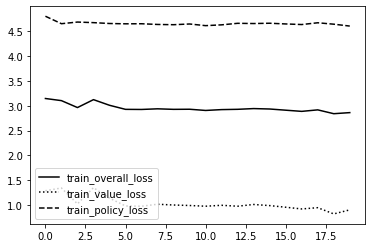

KeyboardInterrupt: 

In [6]:
######## LOAD MODEL ########

# 빈 Neural Network 생성
current_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)
best_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) +  env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)

# Model 불러옴
if initialise.INITIAL_MODEL_VERSION != None:
    best_player_version  = initialise.INITIAL_MODEL_VERSION
    print('LOADING MODEL VERSION ' + str(initialise.INITIAL_MODEL_VERSION) + '...')
    m_tmp = best_NN.read(env.name, initialise.INITIAL_MODEL_VERSION, best_player_version)
    current_NN.model.set_weights(m_tmp.get_weights())
    best_NN.model.set_weights(m_tmp.get_weights())
#otherwise just ensure the weights on the two players are the same
else:
    best_player_version = 0
    best_NN.model.set_weights(current_NN.model.get_weights())
    print('NEW MODEL ...')

#copy the config file to the run folder
copyfile('./config.py', run_folder + 'config.py')
plot_model(current_NN.model, to_file=run_folder + 'models/model.png', show_shapes = True)

print('\n')

######## CREATE THE PLAYERS ########

current_player = Agent('current_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, current_NN)
best_player = Agent('best_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, best_NN)
iteration = 0

first_training = True

while 1:

    ######## LOAD MEMORIES ########
    
    if initialise.INITIAL_MEMORY_VERSION != None:
        if first_training == False and os.path.exists('./run/memory/memory_temp.p'):
            fileflag.fileFlag_on(0)
            memory = pickle.load( open( "./run/memory/memory_temp" + ".p",   "rb" ) )
            fileflag.fileFlag_off(0)
            print('USING TEMP MEMORY')
            print('MEMORY SIZE: ' + str(len(memory.ltmemory)))

        else :
            memory = pickle.load( open( "./run/memory/memory" + '_' +  str(initialise.INITIAL_MEMORY_VERSION)[0:4] + ".p",   "rb" ) )
            print('USING MEMORY : ' + str(initialise.INITIAL_MEMORY_VERSION))
            print('MEMORY SIZE: ' + str(len(memory.ltmemory)))

    else :
        while not os.path.exists('./run/memory/memory_temp.p'):
            print('Waiting for memory_temp.p')
            time.sleep(10)
        fileflag.fileFlag_on(0)
        memory = pickle.load( open( "./run/memory/memory_temp" + ".p",   "rb" ) )
        fileflag.fileFlag_off(0)
        print('USING TEMP MEMORY')
        print('MEMORY SIZE: ' + str(len(memory.ltmemory)))

    first_trainning = False
    
    
    iteration += 1
    reload(lg)
    reload(config)
    
    print('ITERATION NUMBER ' + str(iteration))

    if iteration % 5 == 0:    
        lg.logger_test.info('Training iteration : %d', iteration)
    
    lg.logger_main.info('BEST PLAYER VERSION: %d', best_player_version)
    print('BEST PLAYER VERSION ' + str(best_player_version))

    ######## RETRAINING ########
    print('RETRAINING...')
    current_player.replay(memory.ltmemory)
    print('')
    fileflag.fileFlag_on(1)
    current_NN.model.save(run_folder + 'models/training_model.h5')
    fileflag.fileFlag_off(1)

    